# Lab 5: Sequence Labeling
605.646 Natural Language Processing

Fall 2025

This is a two-week lab.

## Background

This laboratory explores sequence labeling using a neural sequence tagger. By way of background, you might optionally try the following:
1.	Work	through	this [introductory PyTorch	tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
2.	Work	through	 this	[RNN tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html),	which	has	you	 train	an	RNN	 to	classify surnames based	on their	language/ethnicity.

  What	are	the	top	predictions	for	the	name	McNamee?		How	about	Ocasio-Cortez?
3.	We will be using the FLAIR LSTM-CRF system. Skim	through	[this	paper](https://aclanthology.org/C18-1139/) for details on how the system works.

## Setting Up and Running the Tagger

This notebook describes how to run the FLAIR LSTM/CRF tagger on Colab. You will be using your Google drive to store your project code and data. In the following, most of the manipulation of files on your drive are done through Colab. However, it's fine to use the Google Drive interface if you prefer. You may also use a platform other than Colab if you prefer. If you use Colab, you will likely need to pay for a Colab Pro subscription to avoid timeouts (it costs far less than a textbook and can be canceled whenever you want).


This lab needs to run on a GPU. Click the 'runtime' menu above, select 'change runtime type' and verify you're using a GPU.

First, install the FLAIR and gensim packages. This can take as long as three minutes depending on your machinery.

In [29]:
!pip install flair --quiet
!pip install flair[word-embeddings]

zsh:1: no matches found: flair[word-embeddings]


You might see version errors, but they do not appear to affect the tagger's operation.

Import various modules.

In [35]:
import flair
from flair.embeddings import (
    WordEmbeddings,
    FlairEmbeddings,
    StackedEmbeddings,
)
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.data import Corpus, Sentence
from flair.datasets import ColumnCorpus
from pathlib import Path

Mount your Google drive. You will be prompted to sign in to your Google account.

In [3]:
from google.colab import drive

gdrive_mount = "/content/drive"
drive.mount(gdrive_mount, force_remount=True)

Mounted at /content/drive


Create a directory to house your project, and move to it. The ! spawns a new process, while the % executes the command in the current process. Note that we need to put quotes around the directory name to run this in a Notebook because in their infinite wisdom Google has placed a space in the default gdrive path.

In [ ]:
# Change this path if you'd like to work on your lab in a different directory:
labdir = "/content/drive/My Drive/Teaching/605.646/Fall 2025/lab05"
!mkdir -p "$labdir"
%cd "$labdir"

/content/drive/My Drive/Teaching/605.646/Fall 2025/lab05


Now, outside of Colab, obtain the file ```conll03-englishversion.gz``` from Canvas, ungzip it, and place the resulting directory in your $labdir. Notice that the data is broken into training, dev (called ```valid.txt``` here) and testing partitions.

In [2]:
datadir = "conll03-englishversion"
!ls "$datadir"

metadata  test.txt  train.txt valid.txt


## Tagger Training

We're now ready to train a tagger. We'll start by naming our run.

In [3]:
runname = "flair-ner-conll-eng3"

Next, we'll marshal the CoNLL 2003 English named entity recognition data.

In [4]:
# 1. Create the corpus
columns = {0: "text", 1: "pos", 2: "chunk", 3: "ner"}
corpus = ColumnCorpus(
    datadir,
    columns,
    train_file="train.txt",
    dev_file="valid.txt",
    test_file="test.txt",
)
print(corpus)

2025-10-21 23:21:42,121 Reading data from conll03-englishversion
2025-10-21 23:21:42,126 Train: conll03-englishversion/train.txt
2025-10-21 23:21:42,127 Dev: conll03-englishversion/valid.txt
2025-10-21 23:21:42,131 Test: conll03-englishversion/test.txt
Corpus: 14987 train + 3466 dev + 3684 test sentences


In [5]:
# 2. Select the label to predict
label_type = "ner"

In [6]:
# 3. Create a label dictionary from the corpus
label_dict = corpus.make_label_dictionary(
    label_type=label_type, add_unk=False
)
print(label_dict)

2025-10-21 23:21:59,560 Computing label dictionary. Progress:


1it [00:00, 145.20it/s]
14987it [00:01, 11233.32it/s]

2025-10-21 23:22:01,036 Dictionary created for label 'ner' with 4 values: LOC (seen 7140 times), PER (seen 6600 times), ORG (seen 6321 times), MISC (seen 3438 times)
Dictionary with 4 tags: LOC, PER, ORG, MISC


The tagger embeds its input using the combination of several models.

In [7]:
# 4. Initialize embedding stack with Flair and GloVe
embedding_types = [
    WordEmbeddings("glove"),
    FlairEmbeddings("news-forward"),
    FlairEmbeddings("news-backward"),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

2025-10-21 23:22:11,672 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /var/folders/c6/xl7vgb4x0yv2t1j8j78ty27w0000gn/T/tmp4ytktg2d


100%|██████████| 69.7M/69.7M [00:06<00:00, 11.0MB/s]  

2025-10-21 23:22:20,066 copying /var/folders/c6/xl7vgb4x0yv2t1j8j78ty27w0000gn/T/tmp4ytktg2d to cache at /Users/a.h./.flair/embeddings/news-forward-0.4.1.pt


2025-10-21 23:22:20,224 removing temp file /var/folders/c6/xl7vgb4x0yv2t1j8j78ty27w0000gn/T/tmp4ytktg2d
2025-10-21 23:22:21,141 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /var/folders/c6/xl7vgb4x0yv2t1j8j78ty27w0000gn/T/tmp1fa4owdy


100%|██████████| 69.7M/69.7M [00:05<00:00, 12.7MB/s]

2025-10-21 23:22:27,551 copying /var/folders/c6/xl7vgb4x0yv2t1j8j78ty27w0000gn/T/tmp1fa4owdy to cache at /Users/a.h./.flair/embeddings/news-backward-0.4.1.pt


2025-10-21 23:22:27,705 removing temp file /var/folders/c6/xl7vgb4x0yv2t1j8j78ty27w0000gn/T/tmp1fa4owdy


Now we'll set up a trainer for our model.

In [8]:
# 5. Initialize the sequence tagger
tagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type=label_type,
)

2025-10-21 23:22:32,729 SequenceTagger predicts: Dictionary with 17 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC


In [9]:
# 6. Initialize the trainer
trainer = ModelTrainer(tagger, corpus)

We're ready to train models using the ```train``` method. We can set a maximum number of epochs here. The model will fully train in fifty to sixty epochs. For most of your experoments, you will want to ensure that you run for the same number of epochs. Twenty epochs should be sufficient for most of your experiments.

You'll see at the start of the output a description of the tagger, indicating that it is a Bi-LSTM with a CRF on top and inputs supplied by a combination of embeddings.

In [ ]:
# 7. Train the model
trainer.train(
    f"resources/taggers/{runname}",
    learning_rate=0.1,
    mini_batch_size=32,
    save_model_each_k_epochs=1,
    monitor_test=True,
    max_epochs=10,
)

2025-10-21 23:57:37,868 ----------------------------------------------------------------------------------------------------
2025-10-21 23:57:37,875 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=19, bias=True)
  (loss_f

  0%|          | 0/58 [00:00<?, ?it/s]

Here are the files that we've built:

In [ ]:
!pwd
!ls -l resources/taggers/$runname

/content/drive/MyDrive/Teaching/605.646/Fall 2025/lab05
total 2023320
-rw------- 1 root root 414160181 Oct  6 04:40 best-model.pt
-rw------- 1 root root    558524 Oct  6 04:39 dev.tsv
-rw------- 1 root root 414160198 Oct  6 04:40 final-model.pt
-rw------- 1 root root      1317 Oct  6 04:35 loss.tsv
-rw------- 1 root root 414160232 Oct  6 04:36 model_epoch_1.pt
-rw------- 1 root root 414160232 Oct  6 04:38 model_epoch_2.pt
-rw------- 1 root root 414160232 Oct  6 04:39 model_epoch_3.pt
-rw------- 1 root root    506400 Oct  6 04:40 test.tsv
-rw------- 1 root root     10412 Oct  6 04:40 training.log


What are these files?
* ```best-model.pt```: the best performing model encountered during training
* ```dev.tsv```: space-separated token, ground truth label, and predicted label for the dev.txt file
* ```final-model.pt```: The model as it stood when training ended
* ```loss.tsv```: A truly tab-separated file with the following columns:
** EPOCH
** TIMESTAMP
** BAD_EPOCHS
** LEARNING_RATE
** TRAIN_LOSS
** DEV_LOSS
** DEV_PRECISION
** DEV_RECALL
** DEV_F1
** DEV_ACCURACY
* ```model_epoch_##.pt```: The model produced at the end of each epoch
* ```test.tsv```: Same as dev.tsv but for test data
* ```training.log```: Same as the output of the notebook cell
Note that most of the ".tsv" files are not really tab-separated; they're white space delimited.
* ```weights.txt```: Model weights (must be specifically requested at training time; we won't use them).

## Tagging Text

We can tag any text we'd like using one of the models we've built.  First, we load some packages.

In [ ]:
from flair.data import Sentence
from flair.models import SequenceTagger

Now we'll load a saved model from disk.

In [ ]:
model = SequenceTagger.load(
    f"{labdir}/resources/taggers/{runname}/final-model.pt"
)
print(model)

2025-10-06 04:40:17,688 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC, <START>, <STOP>
SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      '0-/root/.flair/embeddings/glove.gensim'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirect

We're ready to tag some data. Let's create a sample sentence, then tag it.

In [ ]:
from textwrap import wrap

# create example sentence
sentence = Sentence(
    "The Washington Post reported that Washington DC team the"
    + " Washington Commanders visited George Washington's Mt. Vernon estate."
)
# Use wrap to make sure output doesn't run off page
print("\n".join(wrap(sentence.to_plain_string())), "\n")

# predict the tags
model.predict(sentence)
print("\n".join(wrap(sentence.to_tagged_string())))

The Washington Post reported that Washington DC team the Washington
Commanders visited George Washington's Mt. Vernon estate. 

Sentence[19]: "The Washington Post reported that Washington DC team
the Washington Commanders visited George Washington's Mt. Vernon
estate." → ["Washington Post"/ORG, "Washington DC"/ORG, "Washington
Commanders"/ORG, "George Washington"/PER, "Mt. Vernon"/LOC]


## Assignment

A. (10 points) Train a named entity recognizer as described above on the ```train.txt``` partition of the CoNLL 2003 English NER data.
This will be your 'base run.'
The system will report dev scores at each iteration.
Choose the number of epochs you will use for all of your runs.
Within 20 iterations you should see F1 scores on the dev partition of 95% or better.
You may choose a higher number if you want to see how good your system can get.
You may choose a lower number if you are running out of resources, but be sure to run at least ten epochs.
Report overall precision, recall, and F1 on the test set, as well as precision, recall, and F1 for each of the identified entity types.
Create a plot of the (decreasing) loss values from the training process,
where the x-axis is epoch and the y-axis is loss.
Then, train the system three more times on the same test data.
The purpose here is to see the the variation in scores caused by the randomness inherent in training a neural system.
Report your minimum, mean (of the four values),
and maximum overall F1 scores on the test data.
Plot the F1 performance on both the dev and test data,
where the x-axis is epoch and the y-axis is F1.
You will find all of these data in ```loss.tsv```.

B. (10 points) Examine how performance improves as more training data is used.
The training file has about 220K lines.
First, divide the data into 25K line chunks (preferably splitting between sentences).
[Note: you might be able to use FLAIR's ```Corpus.downsample``` for this, although I have not tried that.]
Then incrementally, train a system on the first chunk, the first two chunks, the first three chunks, etc.
Run each on the same number of iterations as your base run.
Plot the F1 learning curve as additional training data is made available,
where the x-axis is the amount of training data and the y-axis is F1.

C. (10 points) Study how performance changes when we don’t care about entity types.
First, create copies of both the training and the test data and map all entity types in the copies onto a single entity type, ENT
(i.e., map B-PER to B-ENT, I-PER to I-ENT, etc.).
You will end up with just three tags: B-ENT, I-ENT, and O.
Retrain the system on the new data, using the same number of iterations as you did in your first training.
Compare the scores in overall precision, recall, and F1, when type information is included
(using your base run) against this new run that maps all types to ENT.
Describe why you think there is/is not a difference.

D. (10 points) Explore how the system works on examples of your own selection.
First, create a new test file containing at least ten sentences.
You should include at least ten named entities of each of the three types PER, ORG, and LOC.
Your examples should include entities you think will be easy to identify, as well as a variety of difficult cases.
Run the tagger from the best saved model on your test examples.

Include a list of your sentences and the named entities the system found in your sentences in your pdf submission.
Indicate whether the system failed on any of your easy examples, and describe how it fared on your difficult examples.

## Submissions

As usual, your submission is to be a single pdf file.
Please do not submit a huge file.
There is no need to include outputs beyond what is requested.
If your pdf is longer than twenty or thirty pages,
you need to cut something out.
Remember that Colab/Jupyter notebooks have a tendency to truncate outputs over a certain width or length.
Please check your pdf submission to make sure that all the output you want to appear in it is actually there and has not run off the edge of the page.

In [44]:
import matplotlib.pyplot as plt
from typing import Tuple
import pandas as pd
from textwrap import wrap

### Part A

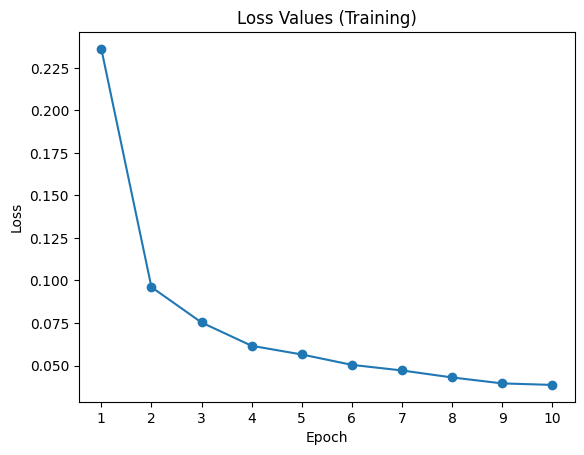

In [11]:
# Plot loss curve for training set
training_log = (
    f"resources/taggers/flair-ner-conll-eng3/training.log"
)
training_df = pd.read_csv(training_log, sep="\t", header=1)

training_losses = []
for i, row in training_df.iterrows():
    if "EPOCH" in row.values[0]:
        epoch_info = row.values[0].split(" ")
        epoch_num = epoch_info[3]
        epoch_loss = float(epoch_info[6])

        training_losses.append(
            {"epoch": epoch_num, "loss": epoch_loss}
        )

training_losses = pd.DataFrame(training_losses)

# Plot line plot
plt.plot(
    training_losses["epoch"],
    training_losses["loss"],
    marker="o",
)
plt.title("Loss Values (Training)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Train model 3 times on train set
runname = "test_model"
num_iterations = 3
for i in range(num_iterations):
    print(f"Training model {i+1}...")
    trainer.train(
        f"resources/taggers/{runname}{3}",
        learning_rate=0.1,
        mini_batch_size=32,
        save_model_each_k_epochs=0,
        monitor_test=True,
        max_epochs=10,
    )

In [27]:
# Evaluate f1 score across training runs (including base)
f1_scores = []
for i in range(num_iterations):
    training_log = (
        f"resources/taggers/test_model{i+1}/training.log"
    )
    training_df = pd.read_csv(
        training_log, sep="\t", header=1
    )

    for _, row in training_df.iterrows():
        if "F-score (macro)" in row.values[0]:
            f1 = float(row.values[0].split(" ")[-1])
            f1_scores.append(
                {"model": f"test_model{i+1}", "f1": f1}
            )

f1_scores.append({"model": "base", "f1": 0.9026})
f1_scores = pd.DataFrame(f1_scores)

min_f1 = f1_scores["f1"].min()
mean_f1 = f1_scores["f1"].mean()
max_f1 = f1_scores["f1"].max()

print(f"F1 scores for all models: \n{f1_scores}")
print(f"min_f1: {min_f1}")
print(f"max_f1: {max_f1}")
print(f"mean_f1: {mean_f1}")

F1 scores for all models: 
         model      f1
0  test_model2  0.9108
1  test_model3  0.9049
2         base  0.9026
min_f1: 0.9026
max_f1: 0.9108
mean_f1: 0.9061


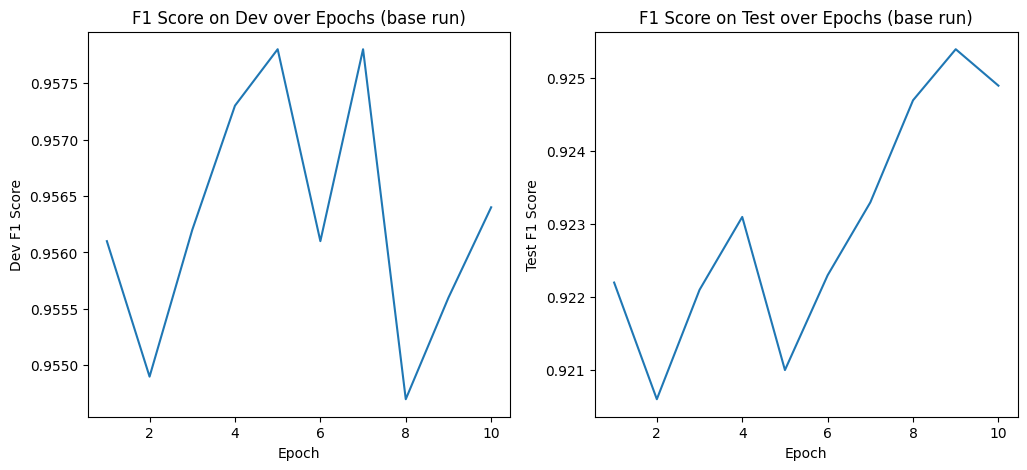

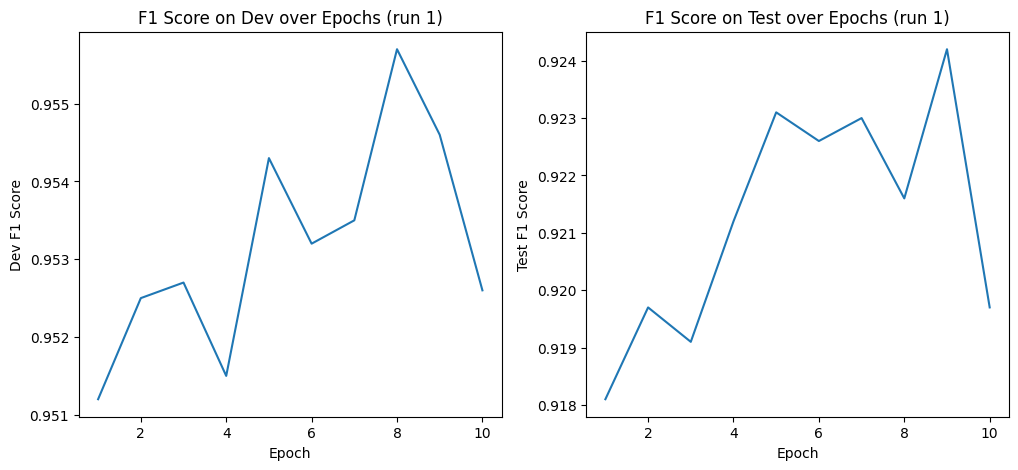

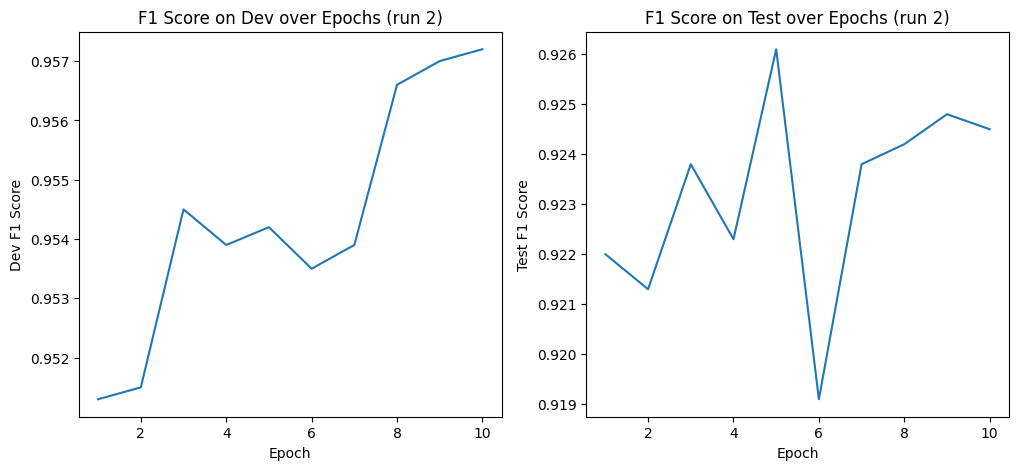

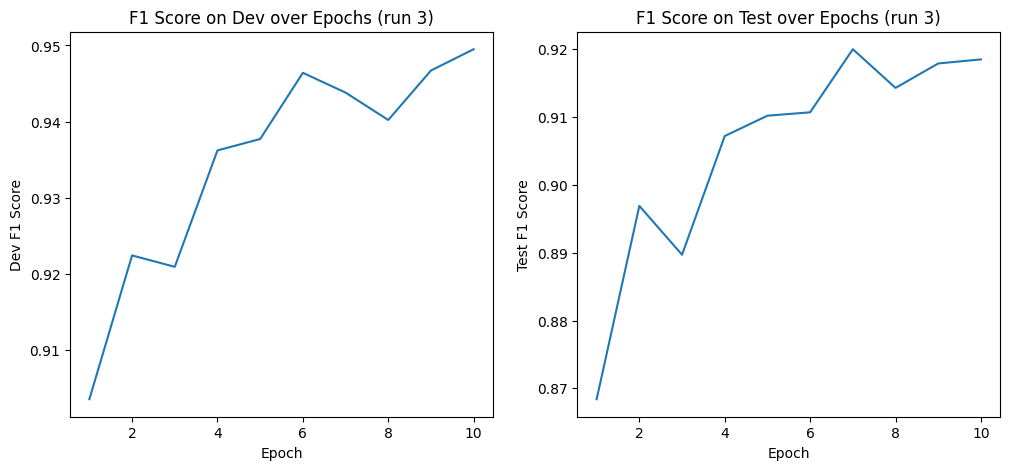

In [25]:
# Plot F1 performance for dev/test for all models
models = [
    "flair-ner-conll-eng3",
    "test_model1",
    "test_model2",
    "test_model3",
]
names = ["base run", "run 1", "run 2", "run 3"]
for i in range(len(models)):
    model = models[i]
    name = names[i]
    loss_file = f"resources/taggers/{model}/loss.tsv"
    loss_df = pd.read_csv(loss_file, sep="\t", header=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(loss_df["EPOCH"], loss_df["DEV_F1"])
    ax1.set_title(f"F1 Score on Dev over Epochs ({name})")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Dev F1 Score")

    ax2.plot(loss_df["EPOCH"], loss_df["TEST_F1"])
    ax2.set_title(f"F1 Score on Test over Epochs ({name})")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Test F1 Score")

    plt.show()

### Part B

In [ ]:
# Split training set into 25k line chunks
line_chunks = 25000
total_lines = 220000
num_chunks = total_lines // line_chunks
training_filepath = "conll03-englishversion/train.txt"

for chunk in range(num_chunks):
    training_data = []
    i = 0
    with open(training_filepath, "r") as f:
        for line in f:
            if i < line_chunks:
                training_data.append(line)
                i += 1
            else:
                break

        # write chunk to new file
        output_filepath = (
            f"training_datasets/trainset_{chunk}.txt"
        )
        with open(output_filepath, "w") as f:
            f.writelines(training_data)

    line_chunks += 25000

In [ ]:
# Iteratively train on each training chunk
columns = {0: "text", 1: "pos", 2: "chunk", 3: "ner"}
for chunk in range(num_chunks):
    # new trainer
    training_file = (
        f"training_datasets/trainset_{chunk}.txt"
    )
    corpus = ColumnCorpus(
        datadir,
        columns,
        train_file=training_file,
        dev_file="valid.txt",
        test_file="test.txt",
    )
    label_dict = corpus.make_label_dictionary(
        label_type=label_type, add_unk=False
    )
    tagger = SequenceTagger(
        hidden_size=256,
        embeddings=embeddings,
        tag_dictionary=label_dict,
        tag_type=label_type,
    )
    trainer = ModelTrainer(tagger, corpus)

    runname = f"model_chunk_{chunk}"
    print(f"Training model chunk {chunk}...")
    trainer.train(
        f"resources/taggers/{runname}",
        learning_rate=0.1,
        mini_batch_size=32,
        save_model_each_k_epochs=0,
        monitor_test=True,
        max_epochs=10,
    )

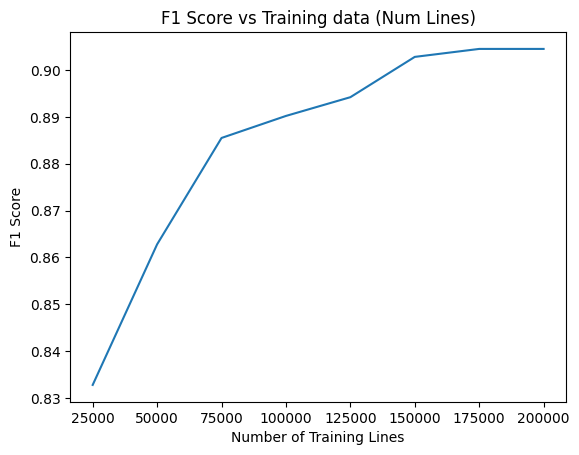

In [26]:
chunks = [0, 1, 2, 3, 4, 5, 6]
lines = [
    25000,
    50000,
    75000,
    100000,
    125000,
    150000,
    175000,
]

# Extract scores for the 6 trained model
f1_scores = []
for chunk in chunks:
    training_log = f"resources/taggers/model_chunk_{chunk}/training.log"
    training_df = pd.read_csv(
        training_log, sep="\t", header=1
    )

    for _, row in training_df.iterrows():
        if "F-score (macro)" in row.values[0]:
            f1 = float(row.values[0].split(" ")[-1])
            f1_scores.append(
                {"lines": lines[chunk], "f1": f1}
            )

# Add base model for full set training result
base_log = (
    f"resources/taggers/flair-ner-conll-eng3/training.log"
)
base_df = pd.read_csv(training_log, sep="\t", header=1)
for _, row in base_df.iterrows():
    if "F-score (macro)" in row.values[0]:
        f1 = float(row.values[0].split(" ")[-1])
        f1_scores.append({"lines": 200000, "f1": f1})

f1_scores = pd.DataFrame(f1_scores)

# Plot F1 over num training lines
plt.plot(f1_scores["lines"], f1_scores["f1"])
plt.title("F1 Score vs Training data (Num Lines)")
plt.xlabel("Number of Training Lines")
plt.ylabel("F1 Score")
plt.show()

### Part C

In [ ]:
# Create train/test set with entity types mapped to "ENT" only
datasets = ["train", "valid", "test"]
for dataset in ["train", "valid", "test"]:
    dataset_filepath = (
        f"conll03-englishversion/{dataset}.txt"
    )
    output_data = []
    with open(dataset_filepath, "r") as f:
        for line in f:
            # empty line requires no modification
            if len(line.split()) < 4:
                output_data.append(line)

            # replace entity types
            else:
                text, pos, chunk, ner = line.split()
                if ner != "O":
                    if ner.startswith("B-"):
                        ner = "B-ENT"
                    else:
                        ner = "I-ENT"

                    output_data.append(
                        f"{text} {pos} {chunk} {ner}\n"
                    )
                else:
                    output_data.append(line)

        output_filepath = (
            f"single_entity_datasets/{dataset}.txt"
        )
        with open(output_filepath, "w") as f:
            f.writelines(output_data)

In [ ]:
# Train model on single-entity datasets
corpus = ColumnCorpus(
    datadir,
    columns,
    train_file="single_entity_datasets/train.txt",
    dev_file="single_entity_datasets/valid.txt",
    test_file="single_entity_datasets/test.txt",
)
label_dict = corpus.make_label_dictionary(
    label_type=label_type, add_unk=False
)
tagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type=label_type,
)
trainer = ModelTrainer(tagger, corpus)

runname = f"model_single_entity"
print(f"Training single entity model...")
trainer.train(
    f"resources/taggers/{runname}",
    learning_rate=0.1,
    mini_batch_size=32,
    save_model_each_k_epochs=0,
    monitor_test=True,
    max_epochs=10,
)

### Part D

In [54]:
# Create custom sentences
test_sentences = [
    "Malala Yousafzai spoke at the\n United Nations in New York City.",
    "My mathematics professor,\n Dr. Smith, teaches me calculus.",
    "The Jonas Brothers is performing\n at Los Angeles next January.",
    "Singapore is a clean and safe\n city-state in Southeast Asia.",
    "My friend, Ashraf, works at the\n World Bank in Paris, France.",
    "June is my sister who is\n older by 10 years than me.",
    "Google was created in\n Stanford University in the year 1998.",
    "The West is a company that focuses on the sale of recycled paper.",
    "The Arizona Cardinals won\n the NFL Championship in 1947.",
    "I visited the Great Wall of\n China during my summer vacation last year.",
]

# Run tagger on sentences
best_model = SequenceTagger.load(
    "resources/taggers/test_model2/best-model.pt"
)
for s in test_sentences:
    sentence = Sentence(s)
    best_model.predict(sentence)
    print("\n".join(wrap(sentence.to_tagged_string())))

2025-10-24 02:42:40,706 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC, <START>, <STOP>
Sentence[12]: "Malala Yousafzai spoke at the  United Nations in New
York City." → ["Malala Yousafzai"/PER, "United Nations"/ORG, "New York
City"/LOC]
Sentence[11]: "My mathematics professor,  Dr. Smith, teaches me
calculus." → ["Dr. Smith"/PER]
Sentence[11]: "The Jonas Brothers is performing  at Los Angeles next
January." → ["Jonas Brothers"/PER, "Los Angeles"/LOC]
Sentence[11]: "Singapore is a clean and safe  city-state in Southeast
Asia." → ["Singapore"/LOC, "Southeast Asia"/LOC]
Sentence[15]: "My friend, Ashraf, works at the  World Bank in Paris,
France." → ["Ashraf"/PER, "World Bank"/ORG, "Paris"/LOC, "France"/LOC]
Sentence[13]: "June is my sister who is  older by 10 years than me."
Sentence[11]: "Google was created in  Stanford University in the year
1998." → ["Google"/ORG, "